In [ ]:
# 차원과 차원축소 cf.1만개의 픽셀을 가진 이미지는 1만개의 특성, 차원을 갖는다. 
# 차원을 줄일 수 있다면 저장공간을 크게 절약할 수 있다.

# 대표적인 차원축소 알고리즘인 주성분 분석, a.k.a.PCA
# 데이터에 있는 분산이 큰 방향을 찾는 것 -> 데이터를 잘 표현하는 어떤 벡터(주성분)
# 주성분 벡터의 원소 개수는 원본 데이터셋에 있는 특성 개수와 같다.
# 주성분을 사용해 원본 데이터의 차원을 줄일 수 있다.
# so, 주성분은 원본 차원과 같고 주성분으로 바꾼 데이터는 차원이 줄어든다

In [14]:
# PCA 클래스
import numpy as np
fruits = np.load('fruits_300.npy')
fruits_2d = fruits.reshape(-1, 100*100)

# n_components 매개변수에 주성분의 개수를 지정해야 한다.
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(fruits_2d)
print(pca.components_.shape)

(50, 10000)


In [15]:
import matplotlib.pyplot as plt
def draw_fruits(arr, ratio=1):
    n = len(arr)
    rows = int(np.ceil(n/10))
    cols = n if rows < 2 else 10
    fig, axs = plt.subplots(rows, cols, figsize=(cols*ratio, rows*ratio), squeeze=False)
    
    for i in range(rows):
        for j in range(cols):
            if i*10+j<n:
                axs[i,j].imshow(arr[i*10+j], cmap='gray_r')
            axs[i,j].axis('off')
    plt.show()

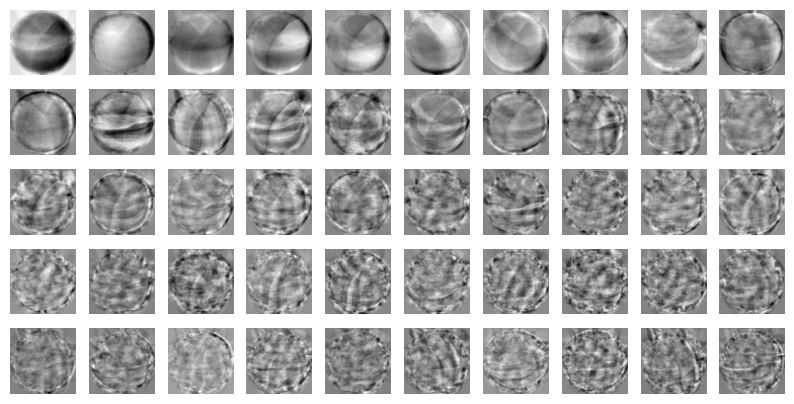

In [16]:
draw_fruits(pca.components_.reshape(-1,100,100))
# 이 주성분은 원본 데이터에서 가장 분산이 큰 방향을 순서대로 나타낸 것 

In [17]:
# 원본데이터를 주성분에 투영하여 특성개수를 10,000개에서 50개로 줄이기
print(fruits_2d.shape)

fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape) # 50개의 특성을 가진 300개의 데이터로 변환

(300, 10000)
(300, 50)


In [18]:
# 원본데이터 재구성(복구)
fruits_inverse = pca.inverse_transform(fruits_pca)
print(fruits_inverse.shape)

(300, 10000)


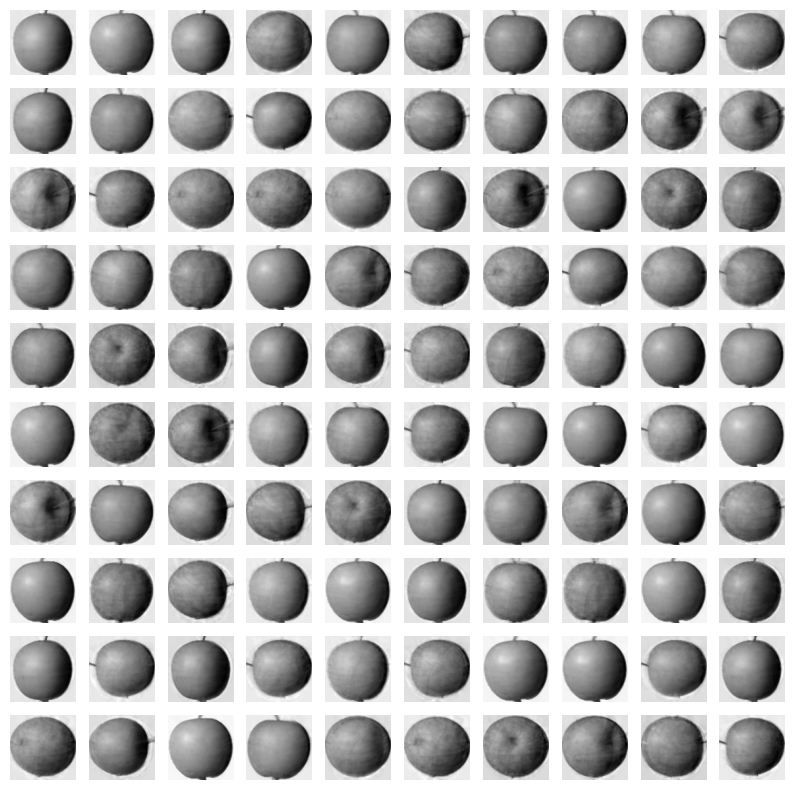

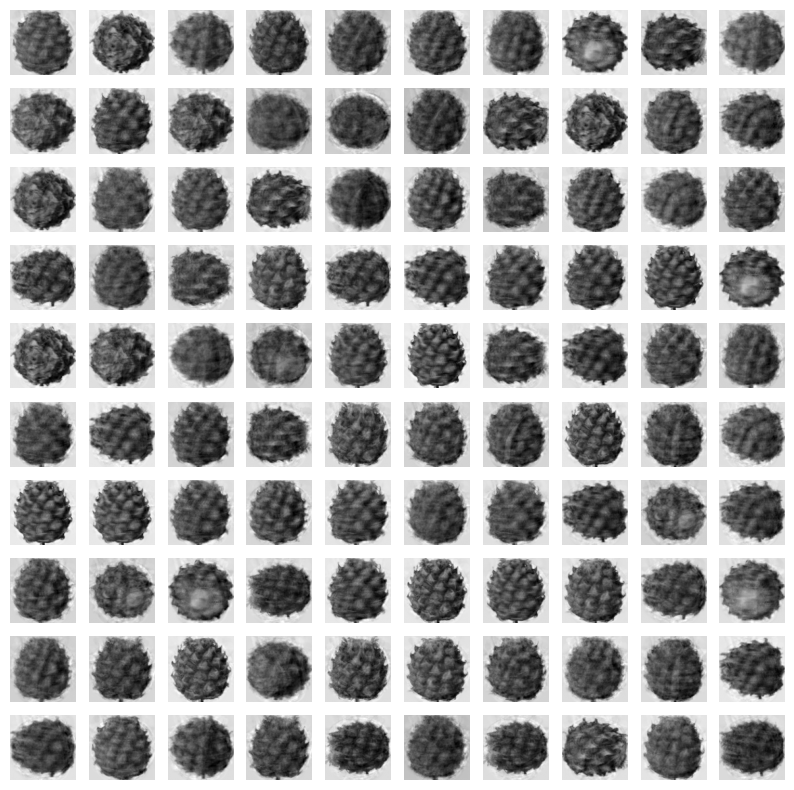

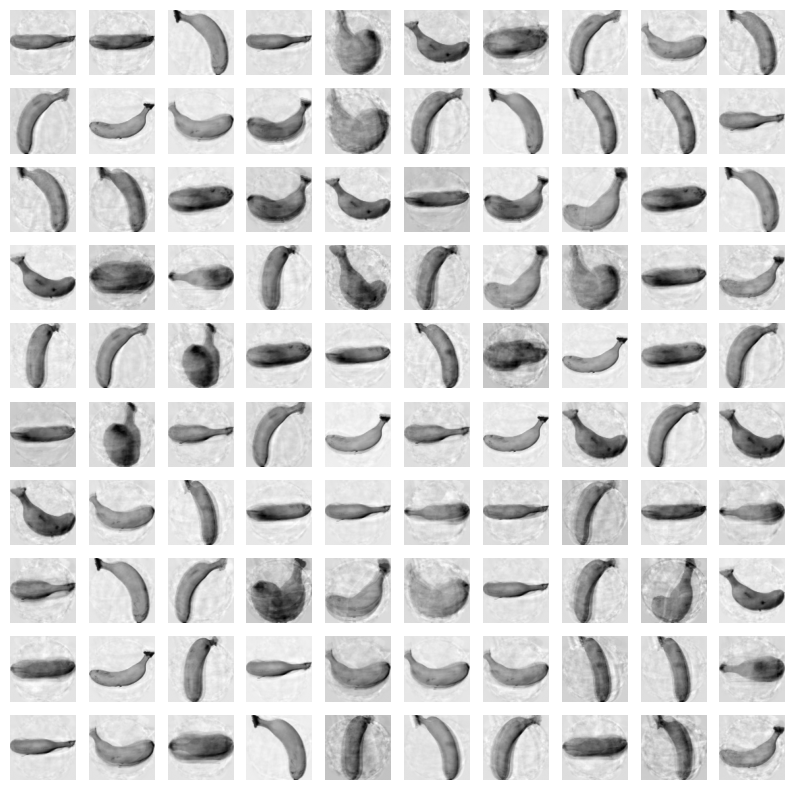

In [19]:
# 100*100 크기로 바꾸어 100개씩 나누어 출력
fruits_reconstruct = fruits_inverse.reshape(-1,100,100)
for start in [0, 100, 200]:
    draw_fruits(fruits_reconstruct[start:start+100])
    print("\n")

In [20]:
# 주성분이 원본 데이터의 분산을 얼마나 잘 나타내는지 기록한 값을 '설명된 분산'이라고 한다.
print(np.sum(pca.explained_variance_ratio_))

0.9215608756876433


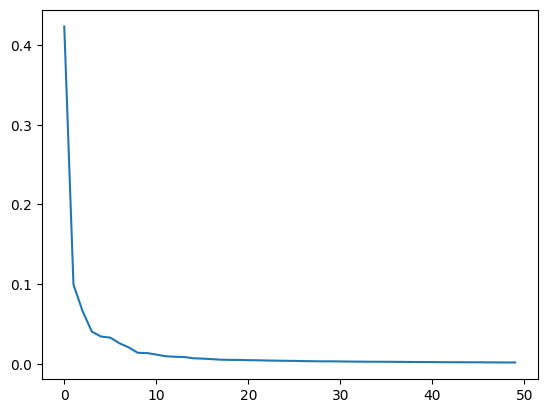

In [21]:
# 설명된 분산의 비율 그래프
plt.plot(pca.explained_variance_ratio_)
plt.show()
# 10개의 주성분이 대부분의 분산을 표현

In [ ]:
# 다른 알고리즘과 함께 사용하기
from sklearn.linear_model import LogisticRegression #로지스티 회귀모델
lr = LogisticRegression()
target = np.array([0]*100 + [1]*100 + [2]*100)

from sklearn.model_selection import cross_validate #교차검증
scores = cross_validate(lr, fruits_2d, target)
print(np.mean(scores['test_score'])) # 과대적합
print(np.mean(scores['fit_time'])) # 교차 검증 폴드의 훈련시간

0.9966666666666667
4.228271007537842


In [ ]:
# PCA로 축소한 모델과 비교
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score'])) # 정확도 동일
print(np.mean(scores['fit_time'])) # 훈련 속도 감소

0.9966666666666667
0.006184148788452149


In [25]:
# n_components 매개변슈에 주성분의 개수가 아닌 분산의 비율을 입력
# 설명된 분산의 50%에 달하는 주성분을 찾도록 하는 PCA모델 만들기
pca = PCA(n_components=0.5)
pca.fit(fruits_2d)
# 찾은 주성분 개수 확인
print(pca.n_components_)

2


In [26]:
# 위 모델로 원본데이터 변환
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 2)


In [ ]:
# 교차검증 결과 확인
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time'])) # 2개의 특성만으로 정확도 99% 달성

0.9933333333333334
0.02297358512878418


/home/parkwooyeol/workspace/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/parkwooyeol/workspace/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/mod

In [28]:
# 차원축소된 데이터를 사용해 k-평균 알고리즘으로 클러스터 찾기
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=42)
km.fit(fruits_pca)
print(np.unique(km.labels_, return_counts=True))

(array([0, 1, 2], dtype=int32), array([110,  99,  91]))


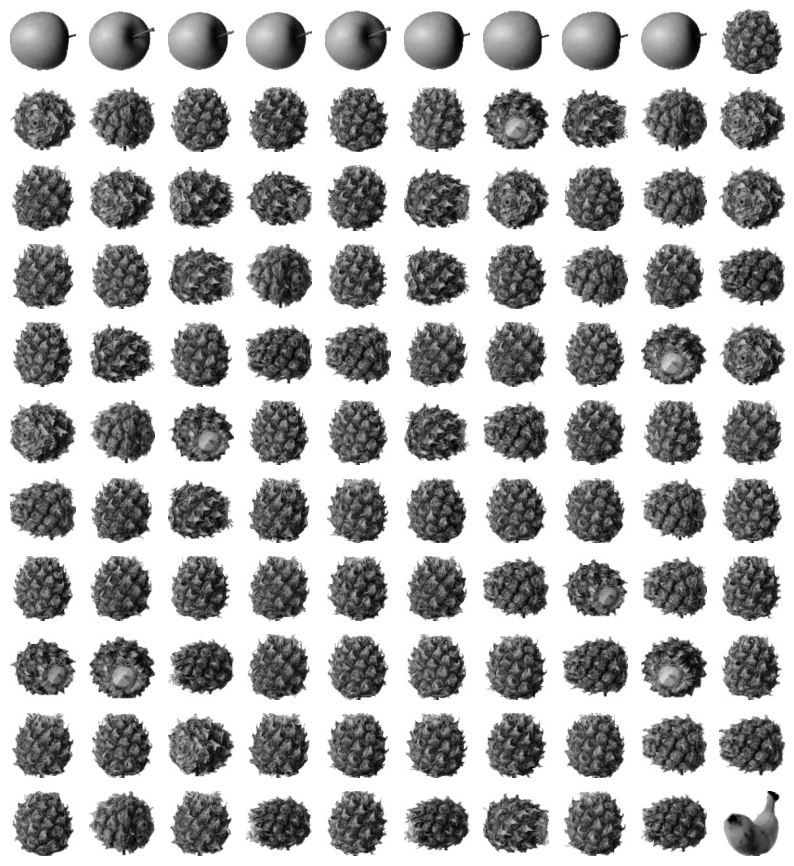

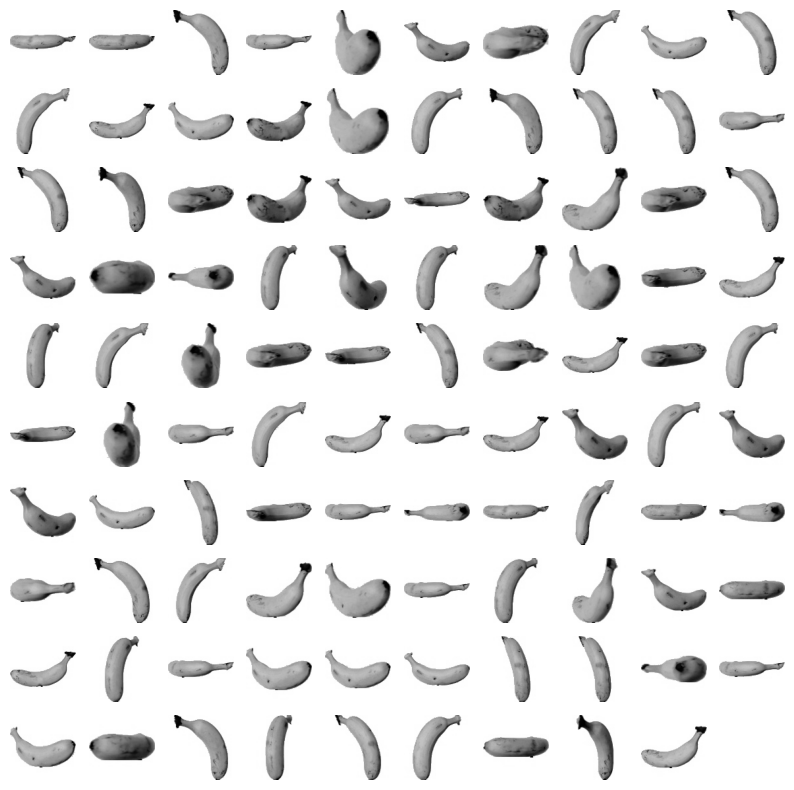

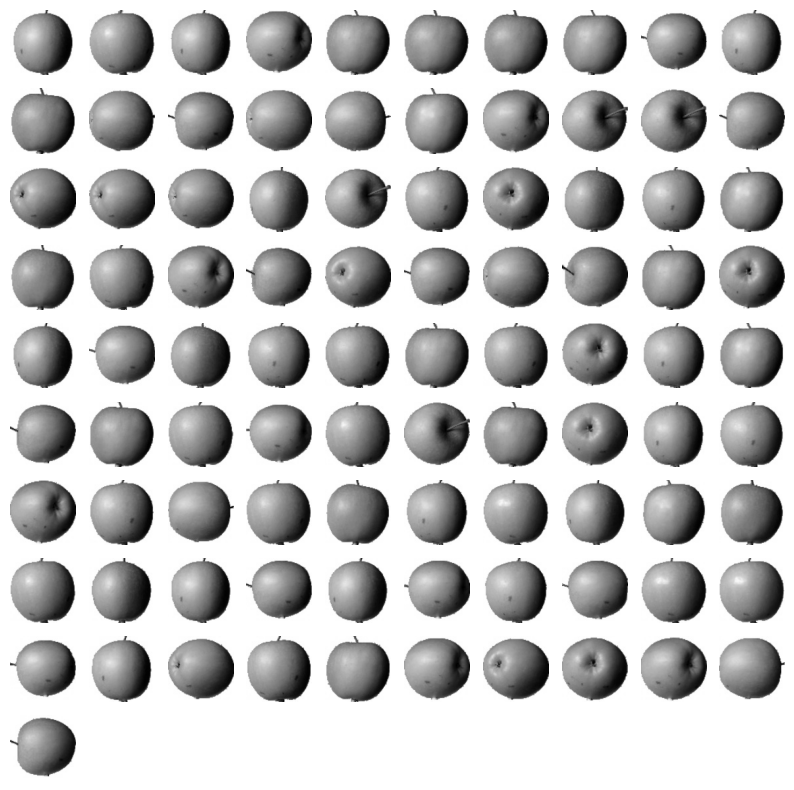

In [ ]:
# 찾은 레이블을 사용해 이미지 출력
for lable in range(0,3):
    draw_fruits(fruits[km.labels_==lable])
    print('\n')

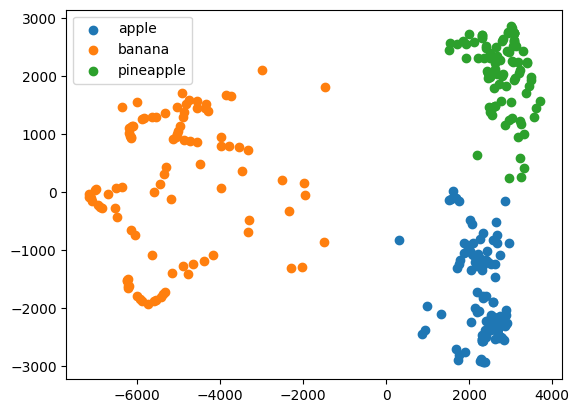

In [32]:
# 찾은 km.lables_를 이용해 클러스터별로 나누어 산점도 그리기
for lable in range(0,3):
    data = fruits_pca[km.labels_==lable]
    plt.scatter(data[:,0], data[:,1])
plt.legend(['apple', 'banana', 'pineapple'])
plt.show()